In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import math
import requests
from io import StringIO
import numpy as np
from datetime import datetime
import matplotlib as plt


housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Mean Squared Error:  125845.27289419805 
R^2:  0.8879861419745849 
95% of home estimates are within 36.47 % of their most recent value 
95% of home estimates are within $ 222320.91 of their most recent value


[Text(0.5, 1.0, 'OLD: Zip Codes with the Worst Performance'),
 Text(0, 0.5, 'What % Higher our Model Prices them')]

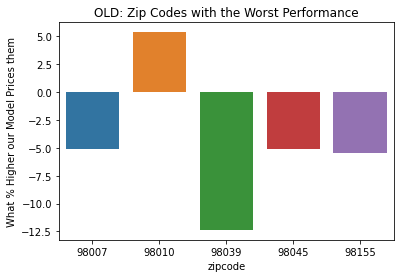

In [27]:
print("Mean Squared Error: ", mean_squared_error(Y_test, predictions, squared=False), 
            "\nR^2: ", r2_score(Y_test,predictions),
            "\n95% of home estimates are within", round((abs(Y_test-predictions)/Y_test).quantile(.95)*100,2), "% of their most recent value",
            "\n95% of home estimates are within $", round(abs(Y_test-predictions).quantile(.95),2), "of their most recent value")


weights = np.where(Y_train < 400000, 2, 1)
#check
equality = pd.concat([(predictions-Y_test)/Y_test*100,X_test1.zipcode],axis=1).groupby('zipcode').median().reset_index()
equality['abs_price'] =equality.price.abs()
equality = equality.sort_values('abs_price',ascending=False)
# The 5 zip codes where our model most consistently under- or over- estimates 
sns.barplot(data=equality.head(),x='zipcode',y='price').set(title='OLD: Zip Codes with the Worst Performance',
                                                            ylabel='What % Higher our Model Prices them')



In [18]:
housing= normalized_irs_housing.drop('date',axis=1)
Y = housing.price
X = housing.drop(['price'],axis=1)
X_train1, X_test1, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_train = X_train1.drop('zipcode',axis=1)
X_test = X_test1.drop('zipcode',axis=1)



model = XGBRegressor(max_depth=5)
model.fit(X_train1, Y_train, sample_weight=weights)
predictions = model.predict(X_test1)
scoring = Y_test - predictions



In [ ]:

model.predict(fix_data(holdout).drop('zipcode',axis=1))
#holdout.drop('zipcode').head()

In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_test, predictions, squared=False)


125845.27289419805

<AxesSubplot: xlabel='price', ylabel='Count'>

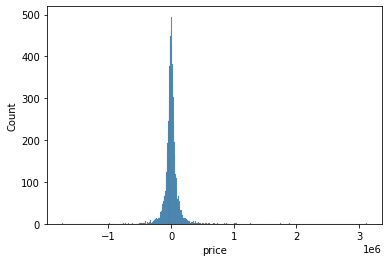

In [25]:
from sklearn.metrics import r2_score
sns.histplot(x=Y_test-predictions)

In [23]:
print("Mean Squared Error: ", mean_squared_error(Y_test, predictions, squared=False), 
            "\nR^2: ", r2_score(Y_test,predictions),
            "\n95% of home estimates are within", round((abs(Y_test-predictions)/Y_test).quantile(.95)*100,2), "% of their most recent value",
            "\n95% of home estimates are within $", round(abs(Y_test-predictions).quantile(.95),2), "of their most recent value")


Mean Squared Error:  125845.27289419805 
 R^2:  0.8879861419745849 
95% of home estimates are within 36.47 % of their most recent value 
95% of home estimates are within $ 222320.91 of their most recent value
95% of home estimates are within 36.47 % of their most recent value


AttributeError: module 'matplotlib' has no attribute 'xticks'

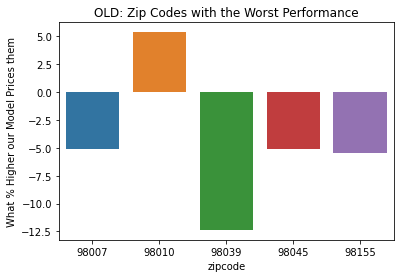


param_grid = {
    'learning_rate': [0.01, 0.05 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [5,10,15]
}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)

In [2]:
def preprocess_and_create_options(df:pd.DataFrame):
    """
    process data and return the following df's 
    normal_df - just fixed bad columns in original data
    added_columns_df - added features based on original columns 
    normalized_df - normalized added_columns_df
    irs_df - augment features based off of IRS data also includes added_columns_df
    normalized_irs_df - normalized irs_df
    """
    # fix bad columns
    df['date'] = [x.split('T')[0] for x in df['date']]

    normal_df = df.copy(deep=True)

    # add new columns
    df['opinion_score'] = df['view'] + df['condition'] + df['grade']
    df['year_of_data'] = [int(x[0:4]) for x in df['date']]
    df['month_of_data'] = [int(x[4:6]) for x in df['date']]
    df['years_since_renovation'] = df['year_of_data'] - (df['yr_renovated'].where(df['yr_renovated'] != 0,df['yr_built']))

    def calculate_distance(lat2, lon2):
        """
        returns the distance of a latitude longitude pair to seattle, washington in kilometers
        """
        # Coordinates of Seattle
        lat1 = 47.6062  # Latitude of Seattle
        lon1 = -122.3321  # Longitude of Seattle

        # Convert latitude and longitude from degrees to radians
        lat1 = math.radians(lat1)
        lon1 = math.radians(lon1)
        lat2 = math.radians(lat2)
        lon2 = math.radians(lon2)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        radius_of_earth = 6371  # Radius of the Earth in kilometers
        distance = radius_of_earth * c

        return distance

    def convert_to_unix_time(date_string):
        date_object = datetime.strptime(date_string, date_format)
        unix_time = int(date_object.timestamp())
        return unix_time

    date_format = "%Y%m%d"
    df['unix_time'] = df['date'].apply(convert_to_unix_time)

    df['kms_to_seattle'] = df.apply(lambda row: calculate_distance(row['lat'], row['long']), axis=1)

    added_columns_df = df.copy(deep=True)

    normalized_df = pd.DataFrame()
    to_normalize = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 
       'sqft_living15', 'sqft_lot15', 'opinion_score', 'year_of_data',
       'month_of_data', 'years_since_renovation',
       'kms_to_seattle']

    scaler = MinMaxScaler()

    for x in df.columns:
        if x in to_normalize:
            normalized_df[x] = scaler.fit_transform(df[ [x] ])
        else:
            normalized_df[x] = df[x]

    # List of attributes to merge 
    # All of these are averages for a zipcode at the year of the sale
    # num in the name refers to number of returns with the given quality
    # other columns are average for that zipcode of the certain thing
    attributes = {
        'A00100': 'gross_income',
        'N00700': 'num_state_refunds',
        'N00900': 'num_business_income',
        'SCHF': 'num_farm_returns',
        'N03300': 'num_slf_emply_rtire_pln',
        'A18425': 'state_local_income_tax',
        'A18450': 'state_local_gen_sales_tax',
        'N18500': 'num_real_estate_taxes',
        'A18500': 'real_estate_tax_amt',
        'A19300': 'mortgage_interest_paid_amt',
        'N07260': 'num_res_energy_tax_cred',
        'TCE': 'num_tax_counsel_for_elderly'
    }

    # Merge the attributes from irs_2014 and irs_2015 into the df dataframe
    for attr, name in attributes.items():
        merged_attr = df.merge(irs_2014[['zipcode', attr]], on='zipcode', how='left')
        merged_attr = merged_attr.merge(irs_2015[['zipcode', attr]], on='zipcode', how='left')
        df[name] = np.where(df['year_of_data'] == 2014, merged_attr[attr + '_x'], merged_attr[attr + '_y'])
    
    irs_df = df.copy(deep=True)

    normalized_irs_df = pd.DataFrame()
    to_normalize = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 
       'sqft_living15', 'sqft_lot15', 'opinion_score', 'year_of_data',
       'month_of_data', 'years_since_renovation', 
       'kms_to_seattle', 'gross_income',
       'num_state_refunds', 'num_business_income', 'num_farm_returns',
       'num_slf_emply_rtire_pln', 'state_local_income_tax',
       'state_local_gen_sales_tax', 'num_real_estate_taxes',
       'real_estate_tax_amt', 'mortgage_interest_paid_amt',
       'num_res_energy_tax_cred', 'num_tax_counsel_for_elderly']

    scaler = MinMaxScaler()

    for x in df.columns:
        if x in to_normalize:
            normalized_irs_df[x] = scaler.fit_transform(df[ [x] ])
        else:
            normalized_irs_df[x] = df[x]
    
    return normal_df, added_columns_df, normalized_df, irs_df, normalized_irs_df

In [3]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')
holdout_mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

def get_data_from_url(url):
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        data = StringIO(response.text)
        df = pd.read_csv(data)
        # Now you can work with the dataframe
        return df
    else:
        print("Error: Unable to retrieve data from the URL.")
        return None
    
global irs_2014
global irs_2015

irs_2014 = get_data_from_url('https://www.irs.gov/pub/irs-soi/14zpallnoagi.csv') 
irs_2015 = get_data_from_url('https://www.irs.gov/pub/irs-soi/15zpallnoagi.csv') 

irs_2014['zipcode'] = irs_2014['ZIPCODE']
irs_2015['zipcode'] = irs_2015['ZIPCODE']

In [4]:
normal_housing, added_columns_housing, normalized_housing, irs_housing, normalized_irs_housing = preprocess_and_create_options(housing)
normal_holdout, added_columns_holdout, normalized_holdout, irs_holdout, normalized_irs_holdout = preprocess_and_create_options(holdout)
normal_holdout_mini, added_columns_holdout_mini, normalized_holdout_mini, irs_holdout_mini, normalized_irs_holdout_mini = preprocess_and_create_options(holdout_mini)

In [8]:
normalized_irs_housing.dtypes

id                               int64
date                            object
bedrooms                       float64
bathrooms                      float64
sqft_living                    float64
sqft_lot                       float64
floors                         float64
waterfront                     float64
view                           float64
condition                      float64
grade                          float64
sqft_above                     float64
sqft_basement                  float64
yr_built                         int64
yr_renovated                     int64
zipcode                          int64
lat                            float64
long                           float64
sqft_living15                  float64
sqft_lot15                     float64
price                          float64
opinion_score                  float64
year_of_data                   float64
month_of_data                  float64
years_since_renovation         float64
unix_time                